In [7]:
import os,sys
import pandas as pd
import numpy as np
import sympy as sym
import time
import re
import types
import ast
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.fenics import FEniCSPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

reference= 'ec_reactions'
dbfile = os.path.abspath(os.path.join(os.path.pardir, 'database', 'tcg_slb_database.tar.gz'))
dbpath = "file://{}".format(dbfile)
dbpath

'file:///workspaces/tcg-ec/systems/ec/database/tcg_slb_database.tar.gz'

In [8]:

#                 cpx         opx    gt          fld         qtz         ky
mi0 = np.asarray([0.53843246, 0.0, 0.17190823, 0.2712644,  0.09867687, 0.0]) # initial modal phase assemblage

Cik0 = np.asarray([            # initial EM compositions
    0.25, 0.23, 0.22, 0.0, 0.3,   # di, hed, clinoenstatite, CaTs, jd
    0.75, 0.24, 0.0, 0.0,      # en, fsl, MgTs, OrthoDi
    0.4, 0.4, 0.2, 0.0, 0.0,   # py, al, gs, Mg, Na
    0.9, 0.1,                  # An, Ab
    1.,                        # qtz
    1.,                        # ky
])
    
display(mi0)
display(Cik0)


def get_reaction(lib):
    pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
    sys.path.append(os.path.join(os.path.pardir, 'database', 'install', lib, 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
    tcgdb = __import__('py_'+lib)
    #rxn = tcgdb.ec1_slb_rx()
    func = getattr(tcgdb,lib) 
    rxn = func() # <-- this should work!
    return rxn

import pickle
from pathlib import Path

get_pickle_path = lambda rxnObj : Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, mi0, Cik0, p_range, T_range, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE):
    if reload:
        return load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, ScipyPDReactiveODE, i0, ['p', 'T'], p_range, T_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_reaction_grid(rxn, bdfgrid, p_range=np.linspace(0.5,2.5,10), T_range=np.linspace(500,1000,10), plot_phases=True):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            axi.axis('off')
            ax = axi.inset_axes([-0.001,-0.005,0.998,0.993])
            ax.patch.set_alpha(0.0)
            #ax.set_xlim([min(p_range), max(p_range)])
            ax.set_xlabel("Pressure (GPa)")

            #ax.set_ylim([min(T_range), max(T_range)])
            ax.set_ylabel("Temperature (K)")

            return ax
        
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
        
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_clim([23.5, 35.])
    s.set_cmap('jet')

    if plot_phases:
        bdfdiag.plot_phases()

def run_reaction(rxnName, mi0, Cik0, p_range, t_range, reload, save):

    rxn = get_reaction(rxnName)

    # initial temperature, pressure and phase volume fraction
    Ti = 1000. # Kelvin
    pi = GPa2Bar(1.0) # bars

    # Opx should not be stable here...

    ode = ScipyPDReactiveODE(rxn)
    end_t = 10000.0
    ode.solve(Ti,pi,mi0,Cik0,end_t)
    display(ode.stime)
    display(ode.final_phases(1.e-2))
    ode.plot()

    grid = solve_reaction_grid(rxn, mi0, Cik0, p_range, t_range, reload=reload, save=save)
    plot_reaction_grid(rxn, grid, p_range, t_range)

array([0.53843246, 0.        , 0.17190823, 0.2712644 , 0.09867687,
       0.        ])

array([0.25, 0.23, 0.22, 0.  , 0.3 , 0.75, 0.24, 0.  , 0.  , 0.4 , 0.4 ,
       0.2 , 0.  , 0.  , 0.9 , 0.1 , 1.  , 1.  ])

In [31]:
run_reaction(
    "ec1_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 50),
    t_range=np.linspace(773.0, 1273.0, 50),
    reload=False,
    save=False
)

ModuleNotFoundError: No module named 'py_ec1_slb_rx'

In [ ]:
run_reaction(
    "ec2_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 50),
    t_range=np.linspace(773.0, 1273.0, 25),
    reload=False,
    save=False
)

ValueError: operands could not be broadcast together with shapes (6,) (5,) 

(array(['Clinopyroxene_slb_ph', 'Garnet_slb_ph', 'Feldspar_slb_ph',
        'Quartz_slb_ph', 'Kyanite_slb_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz', 'ky'], dtype='<U3'))

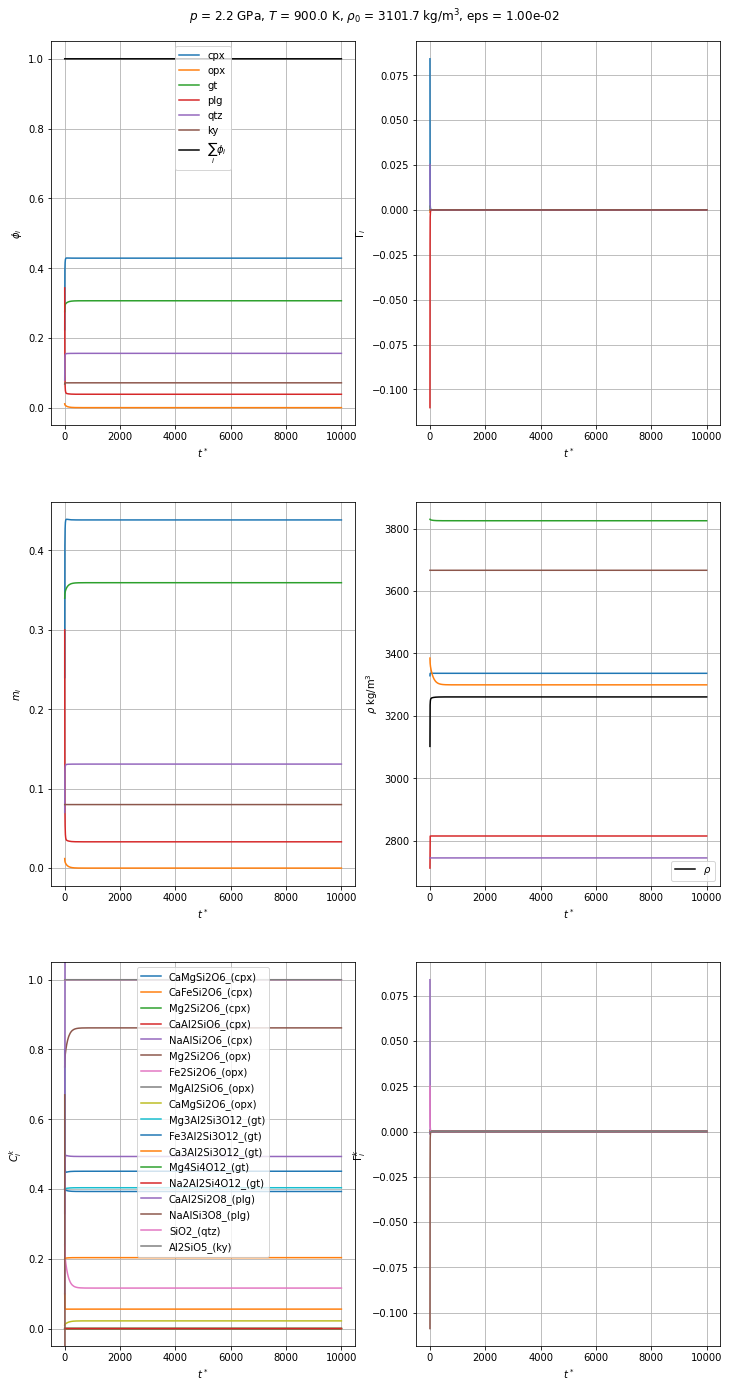

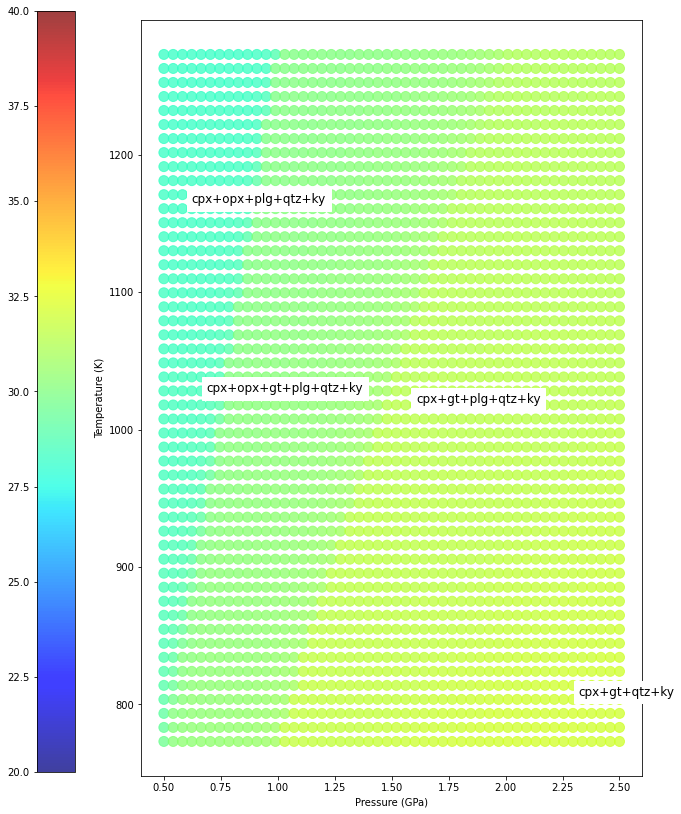

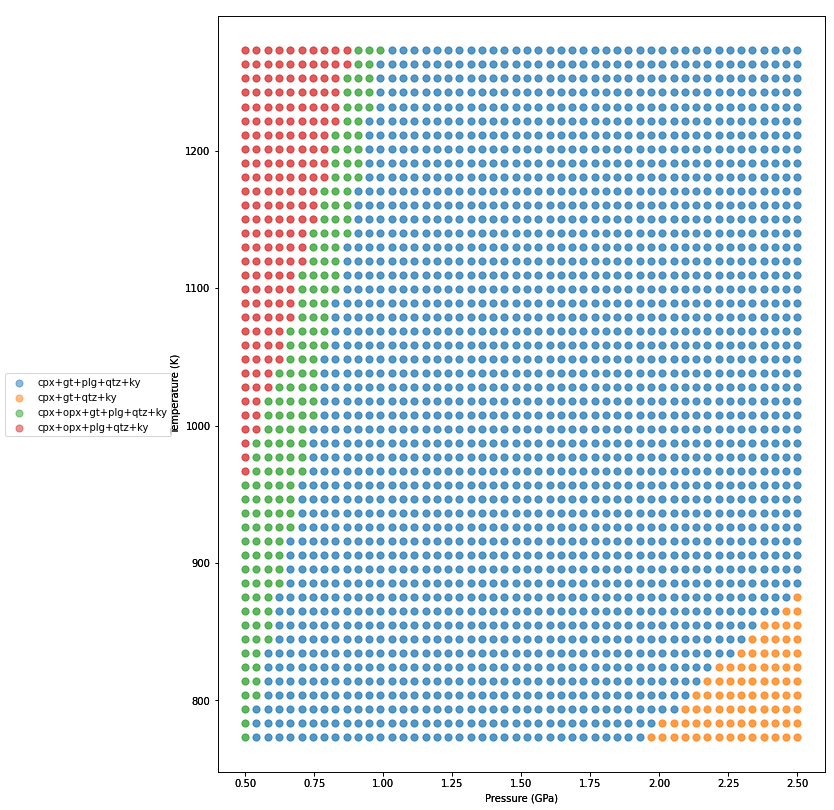

In [ ]:
run_reaction(
    "ec3_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 50),
    t_range=np.linspace(773.0, 1273.0, 50),
    reload=True,
    save=False
)

(array(['Clinopyroxene_slb_ph', 'Orthopyroxene_slb_ph', 'Garnet_slb_ph',
        'Quartz_slb_ph', 'Kyanite_slb_ph'], dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'qtz', 'ky'], dtype='<U3'))

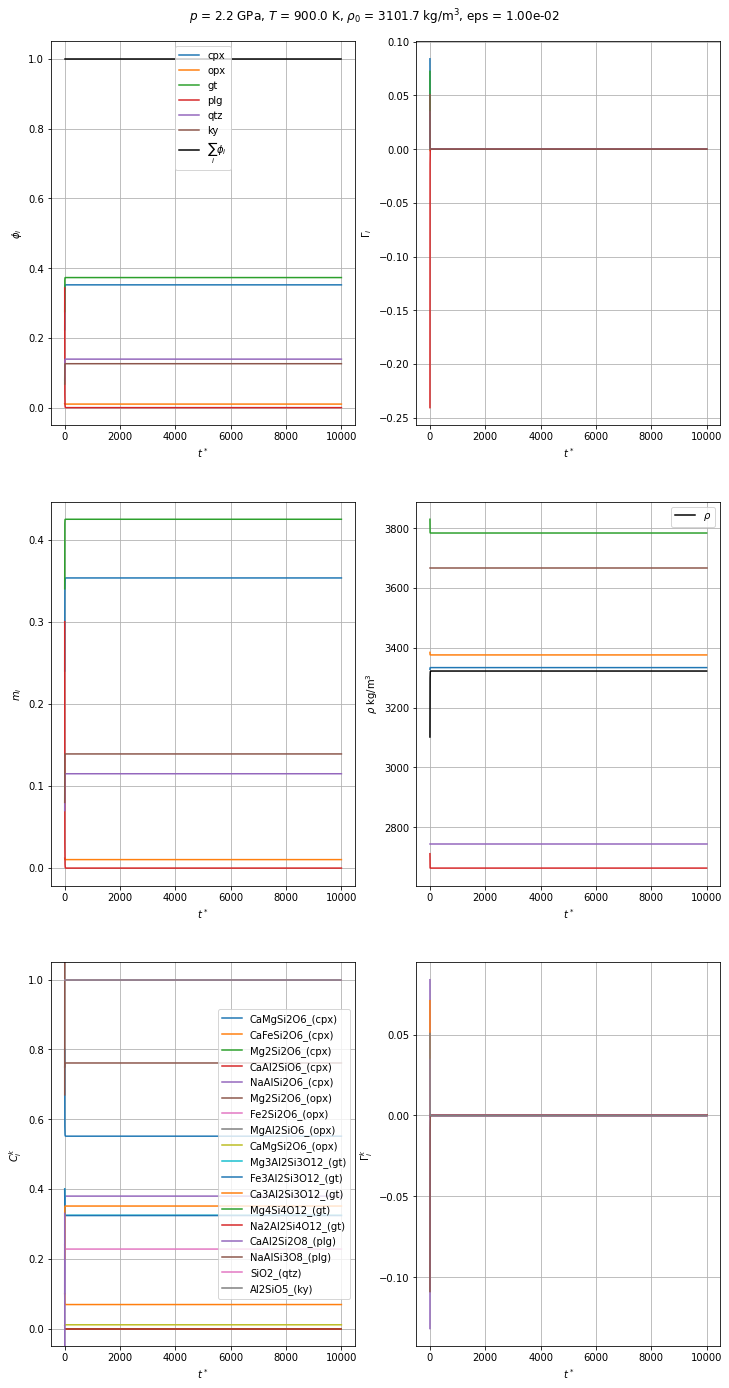

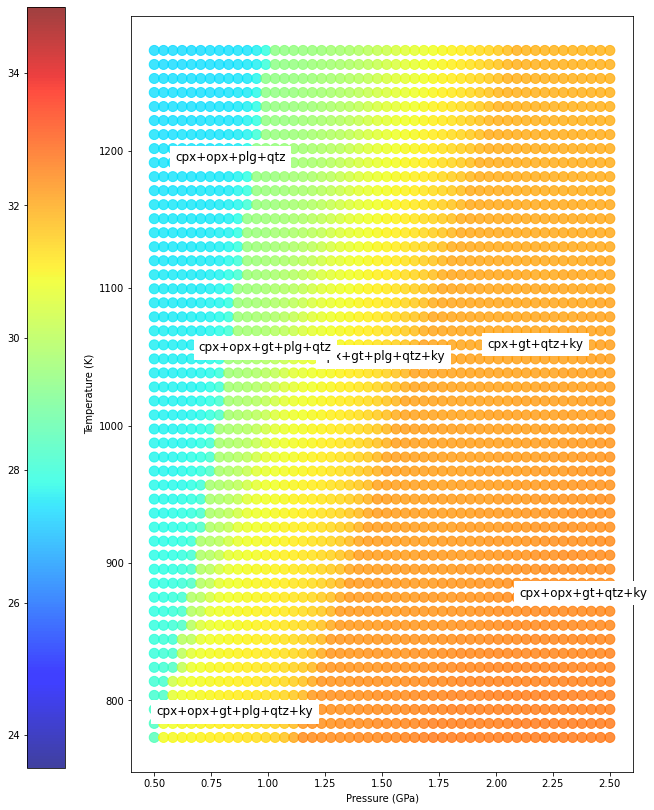

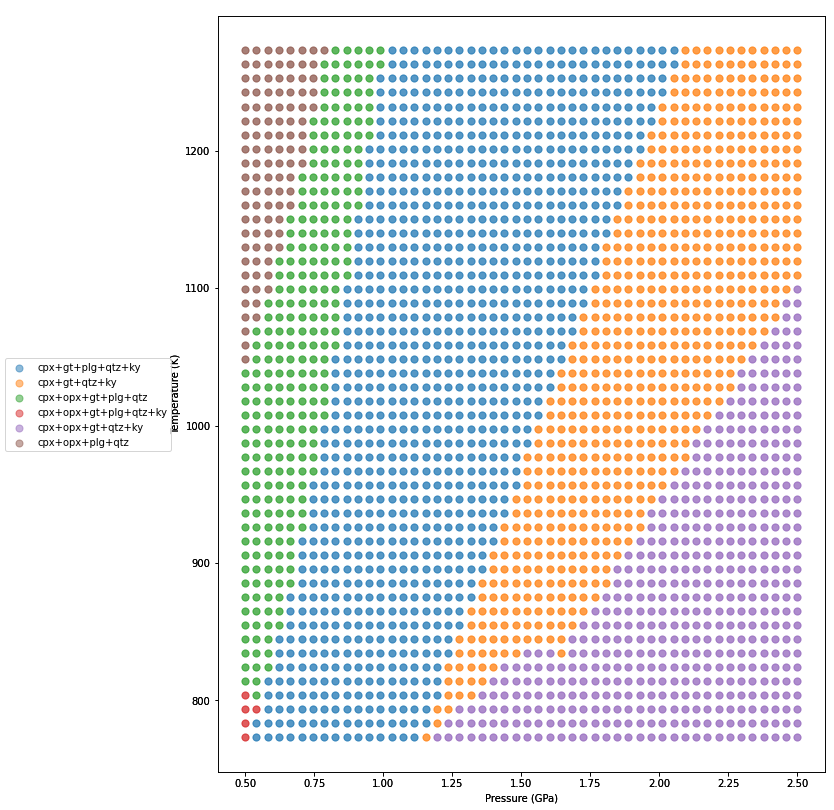

In [ ]:
run_reaction(
    "ec4_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 50),
    t_range=np.linspace(773.0, 1273.0, 50),
    reload=True,
    save=False
)

(array(['Clinopyroxene_slb_ph', 'Garnet_slb_ph', 'Feldspar_slb_ph',
        'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz'], dtype='<U3'))

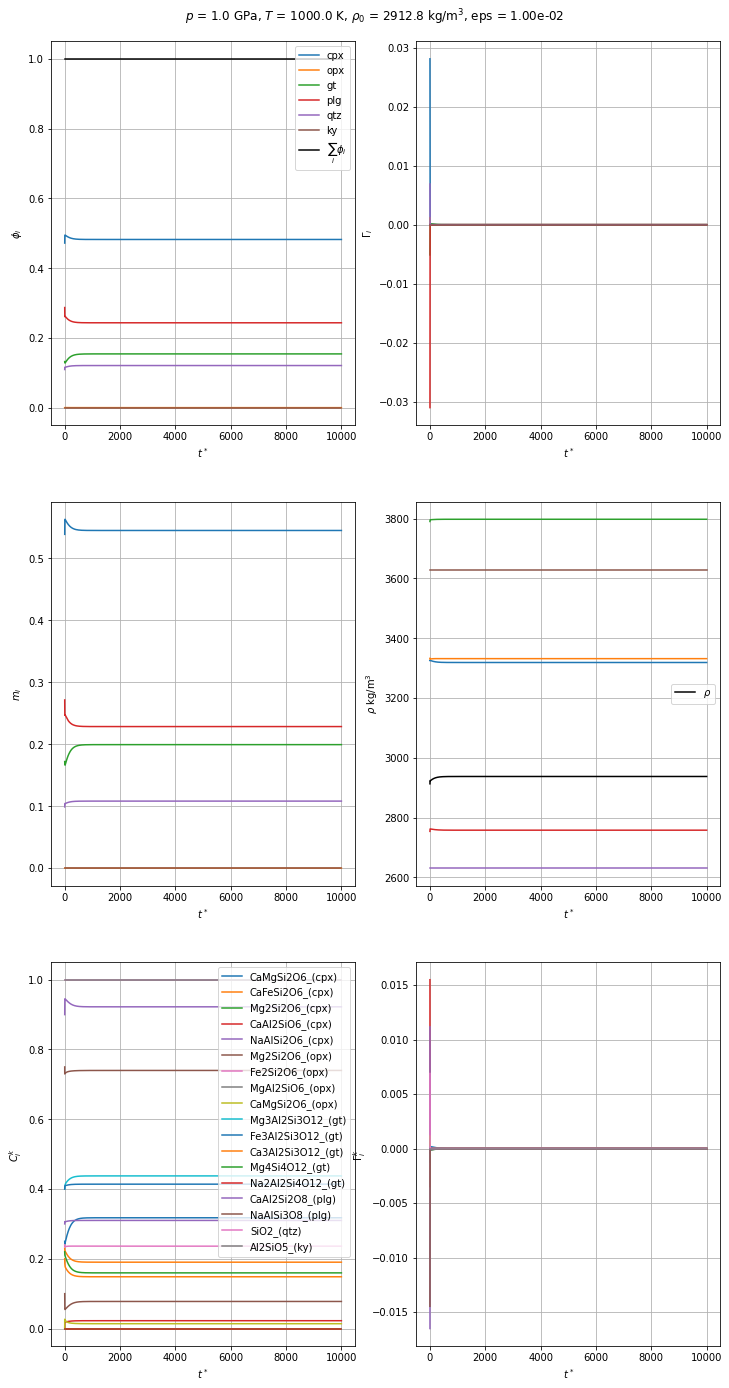

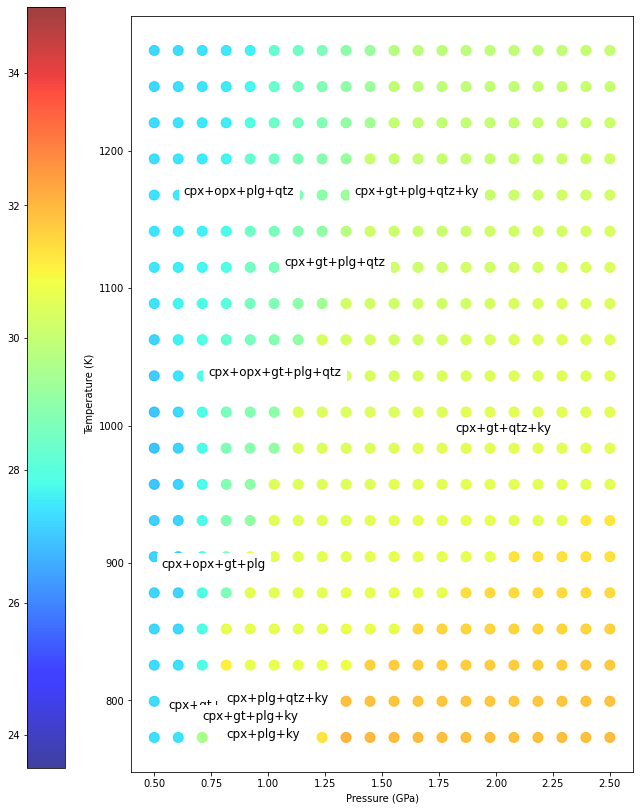

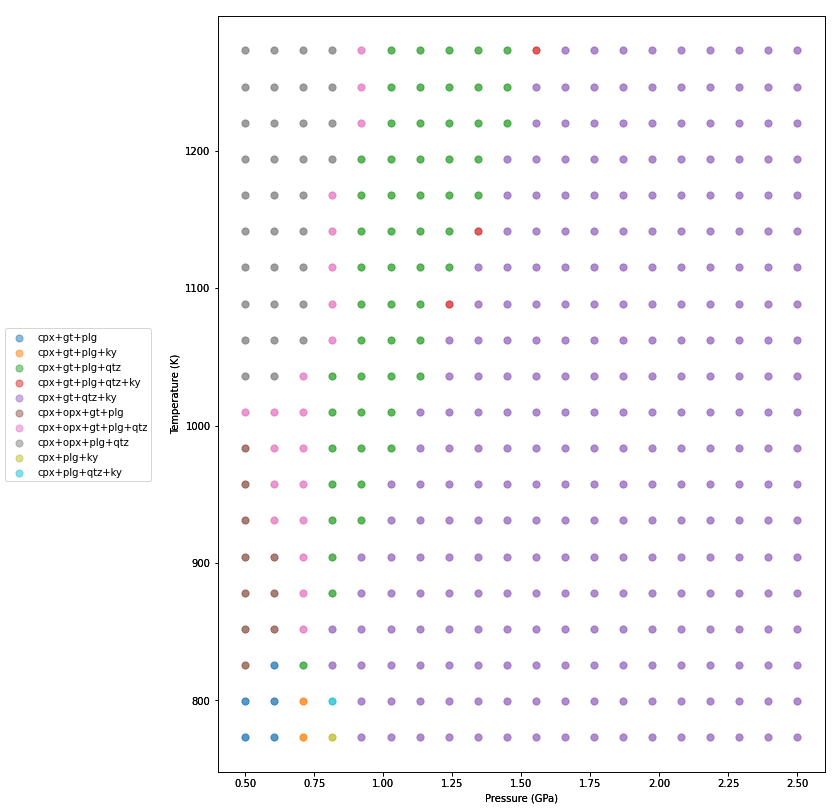

In [11]:
run_reaction(
    "ec5_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 20),
    t_range=np.linspace(773.0, 1273.0, 20),
    reload=False,
    save=True
)
# 20x20 = ~40 mins